# 2022-09-13 • Fit simpler model to STA -- part 2

## Imports

In [1]:
#

In [2]:
using Revise

In [3]:
using MyToolbox

In [4]:
using VoltoMapSim

## Params

In [5]:
p = get_params(
    duration = 10minutes,
    p_conn = 0.04,
    g_EE = 1,
    g_EI = 1,
    g_IE = 4,
    g_II = 4,
    ext_current = Normal(-0.5 * pA/√seconds, 5 * pA/√seconds),
    E_inh = -80 * mV,
    record_v = [1:40; 801:810],
);

## Run sim

In [6]:
s = cached(sim, [p.sim]);

In [7]:
s = augment(s, p);

## Model function

In [13]:
linear_PSP(t; τ1, τ2) =
    
    if (τ1 == τ2)   @. t * exp(-t/τ1)
    else            @. τ1*τ2/(τ1-τ2) * (exp(-t/τ1) - exp(-t/τ2))
    end;

In [14]:
gaussian(x; loc, width) =  

    @. exp(-0.5*( (x-loc)/width )^2);

# Note that unlike in the previous notebook, we do add the 1/2 factor in the exponent here

In [15]:
rescale_to_max!(x) = 
    
    x ./= maximum(abs.(x));

# Note that this returns `NaN`s if x .== 0

In [16]:
centre!(x) = (x .-= mean(x))
centre(x) = centre!(copy(x));

In [17]:
mult!(by) = x -> (x .*= by);

In [18]:
p0 = CVec(
    tx_delay   = 10ms,
    bump = (
        τ1     = 10ms,
        τ2     = 12ms
    ),
    dip = (
        loc    = 40ms,
        width  = 40ms,
        weight = 0.15,
    ),
    scale      = 0mV,
);

FitParams = typeof(p0);

In [38]:
pbounds = CVec(
    tx_delay   = [0, 60ms],
    bump = (
        τ1     = [0, 100ms],
        τ2     = [0, 100ms],
    ),
    dip = (
        loc    = [20ms, 80ms],
        width  = [20ms, 80ms],
        weight = [0, 0.6],
    ),
    scale      = [-2mV, 2mV],
)
pb_flat = collect(CVec(pbounds))
lower = pb_flat[1:2:end]
upper = pb_flat[2:2:end];

In [21]:
function model_STA_components(ep::ExpParams, fp::FitParams)

    Δt::Float64  = ep.sim.general.Δt
    STA_duration = ep.conntest.STA_window_length

    @unpack tx_delay, bump, dip = fp
    
    PSP_duration = STA_duration - tx_delay

    delay_size = round(Int, tx_delay / Δt)
    PSP_size   = round(Int, PSP_duration / Δt)
    STA_size   = round(Int, STA_duration / Δt)

    t_PSP = collect(linspace(0, PSP_duration, PSP_size))
    t_STA = collect(linspace(0, STA_duration, STA_size))
    
    add_delay(x) = vcat(zeros(Float64, delay_size), x)
    
    # τ1, τ2 = bump
    bump = (
        linear_PSP(t_PSP; bump.τ1, bump.τ2)
        |> rescale_to_max!
        |> add_delay
    )
    
    # loc, width, weight = bump
    dip = (
        gaussian(t_STA; dip.loc, dip.width)
        |> rescale_to_max!
        |> mult!(-dip.weight)
    )
    
    return (; bump, dip)
end


function model_STA(ep::ExpParams, fp::FitParams)
    bump, dip = model_STA_components(ep, fp)
    STA = (
        bump .+ dip
        |> mult!(fp.scale)
        |> centre!
    )
end;

## Fit

In [22]:
using LsqFit

In [34]:
# Code to adapt to LsqFit's API

p_buffer = copy(CVec(p0))

function toCVec(params::Vector, cv_buffer::CVec = p_buffer)
    cv_buffer .= params
    return cv_buffer
end

function fit_STA(STA, p0)
    model(xdata, params) = model_STA(p, toCVec(params))
    xdata = []  # Our model function generates 
                # xdata itself (it's alway the same).
    ydata = centre(STA)
    p0_vec = collect(CVec(p0))
    fit = curve_fit(model, xdata, ydata, p0_vec; lower, upper)
end;

In [35]:
using PyPlot
using VoltoMapSim.Plot

In [36]:
function fit_STA(m::Int, p0 = p0, plot = true)
    STA = calc_STA(m=>1, s, p)
    fitt = fit_STA(STA, p0)
    fp = toCVec(fitt.param)
    bump, dip = model_STA_components(p, fp)
    sgn = sign(fp.scale)
    plt.subplots()
    plotsig(sgn * bump, p)
    plotsig(sgn * dip, p)
    plt.subplots()
    plotsig(centre(STA) / mV, p, hylabel = "STA $m → 1")
    plotsig(model_STA(p, fp) / mV, p)
    println(NamedTuple(fp))
    return fp
end;

(tx_delay = 0.0101, bump = (τ1 = 0.0109, τ2 = 0.0111), dip = (loc = 0.0326, width = 0.0349, weight = 0.447), scale = -0.002)


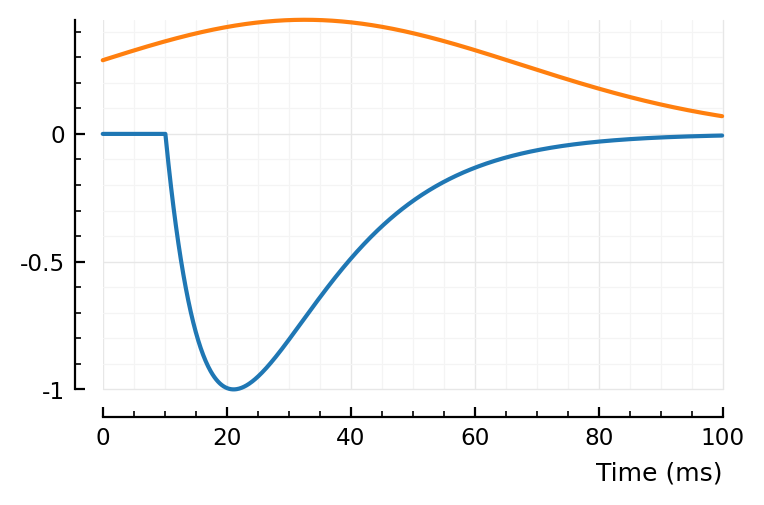

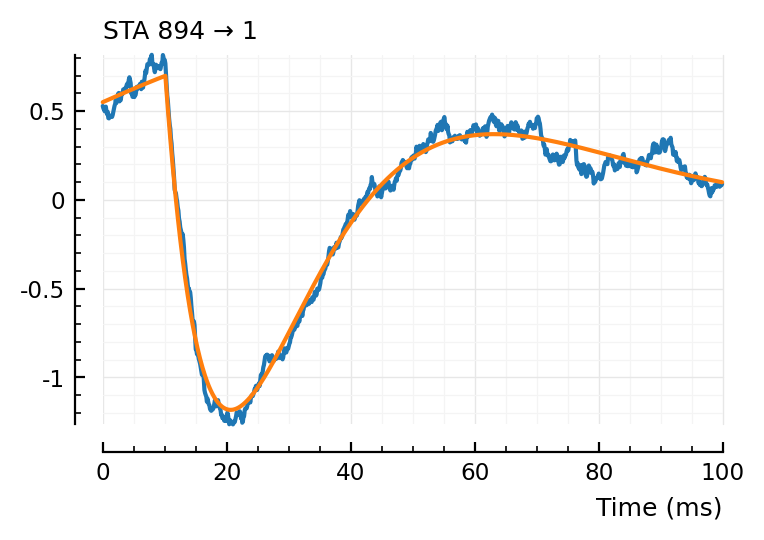

In [28]:
fit_STA(894);

Aha! So it was the problem :D

Great. (Lesson: make parameters independent of each other).

Now to retry the STAs fitted two nb's earlier.

## Exc inputs

(tx_delay = 0.0131, bump = (τ1 = 0.0131, τ2 = 0.0129), dip = (loc = 0.08, width = 0.08, weight = 0), scale = 0.000357)
(tx_delay = 0.0128, bump = (τ1 = 0.0112, τ2 = 0.0111), dip = (loc = 0.0508, width = 0.02, weight = 0.548), scale = 0.000371)
(tx_delay = 0.018, bump = (τ1 = 0.00883, τ2 = 0.0168), dip = (loc = 0.08, width = 0.02, weight = 0.122), scale = 0.000218)


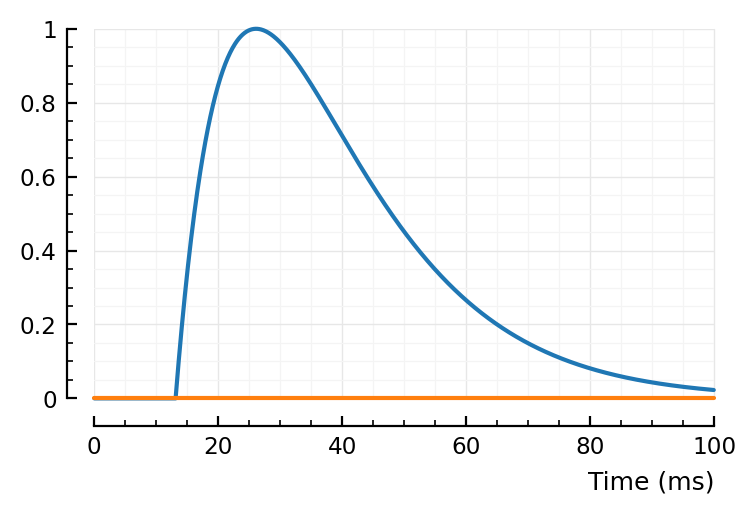

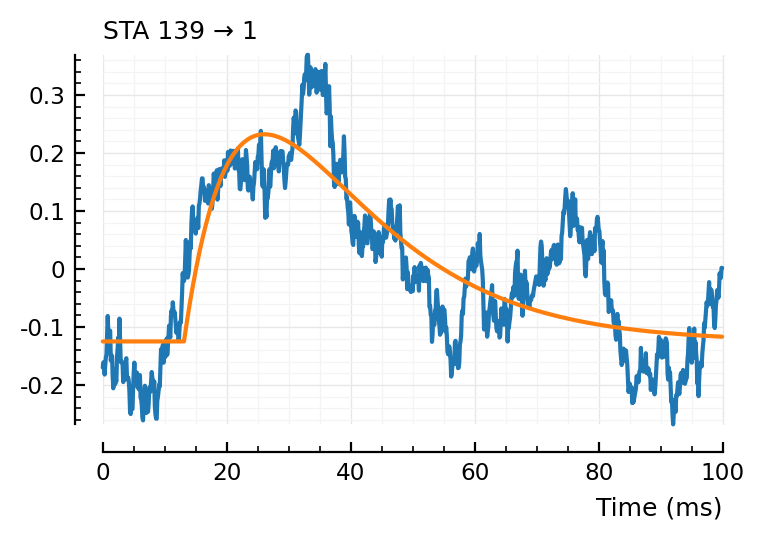

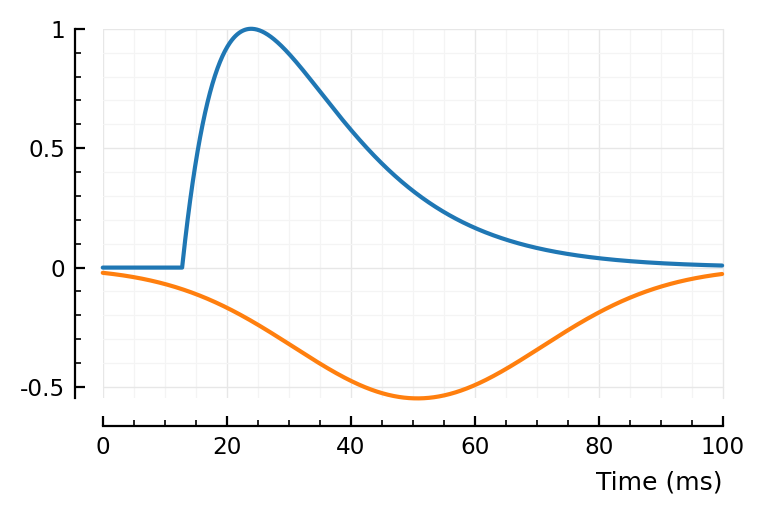

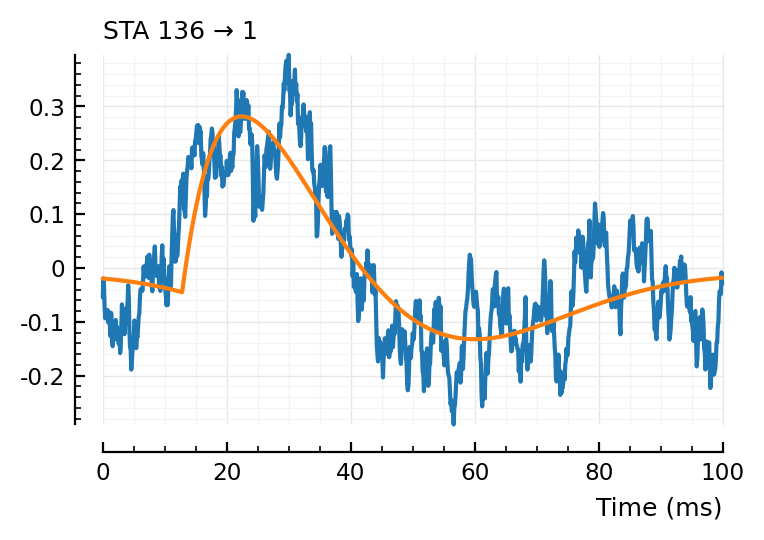

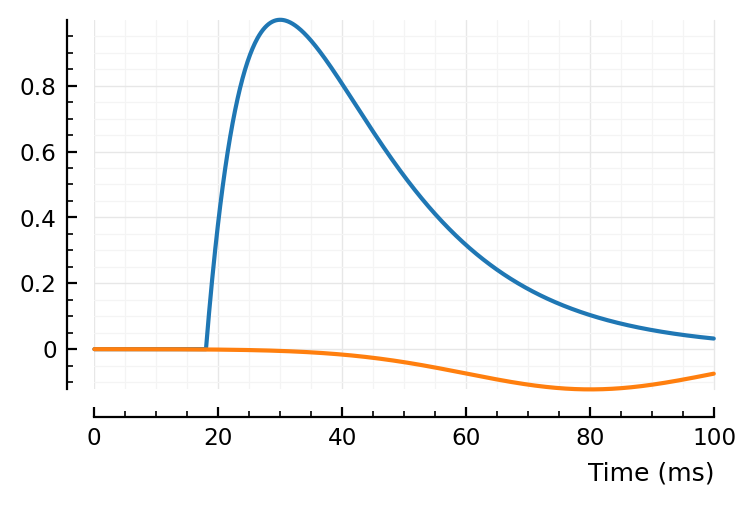

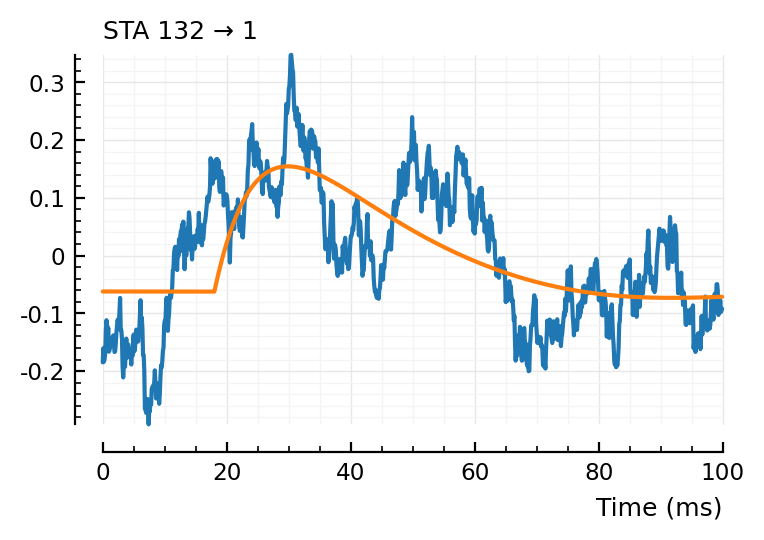

In [29]:
fit_STA.([139, 136, 132]);

Excellent. No more wonky fits.

(The last one had ptp pval 0.03 btw. And avgSTA cor pval 0.12)

## Inh inputs

(tx_delay = 0.0104, bump = (τ1 = 0.00822, τ2 = 0.00841), dip = (loc = 0.0739, width = 0.023, weight = 0), scale = -0.00039)
(tx_delay = 0.0101, bump = (τ1 = 0.0109, τ2 = 0.0111), dip = (loc = 0.0326, width = 0.0349, weight = 0.447), scale = -0.002)
(tx_delay = 0.0352, bump = (τ1 = 0.0164, τ2 = 0.000177), dip = (loc = 0.08, width = 0.02, weight = 1), scale = -0.000179)


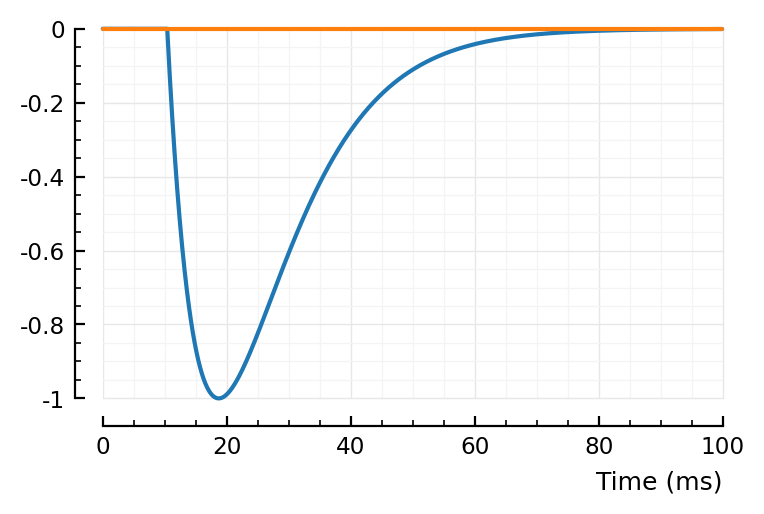

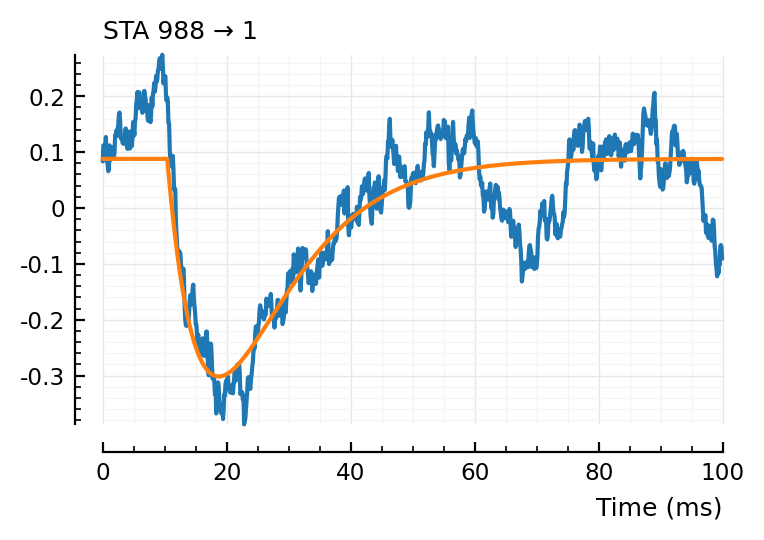

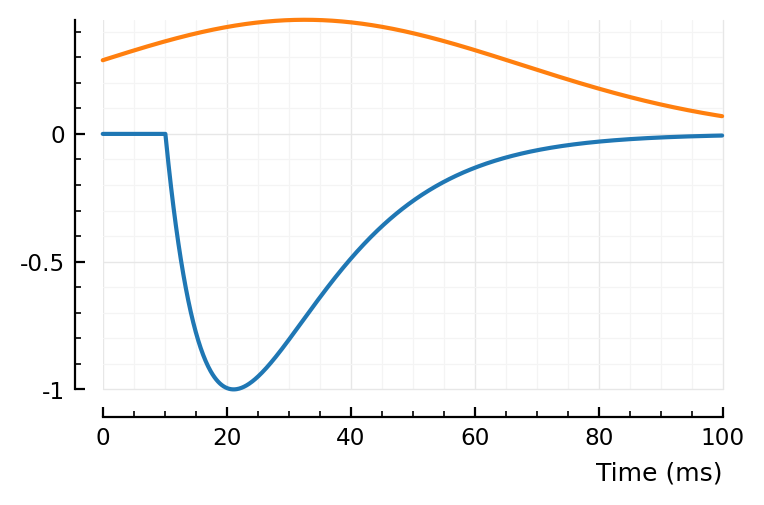

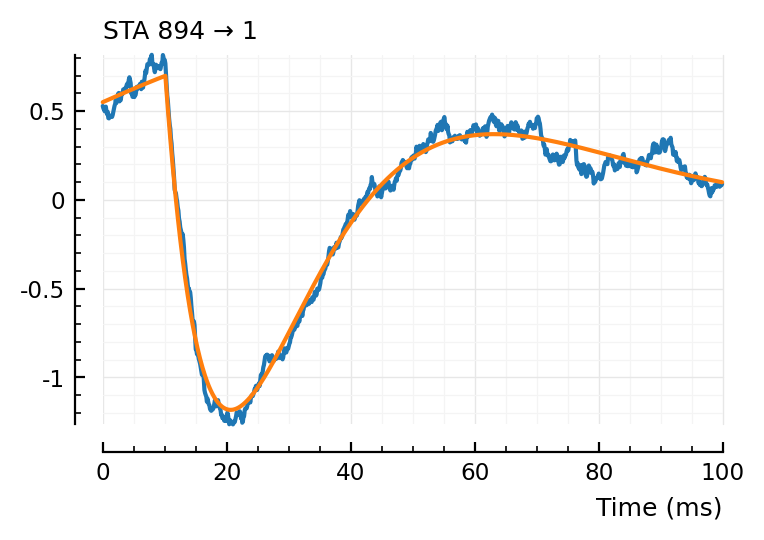

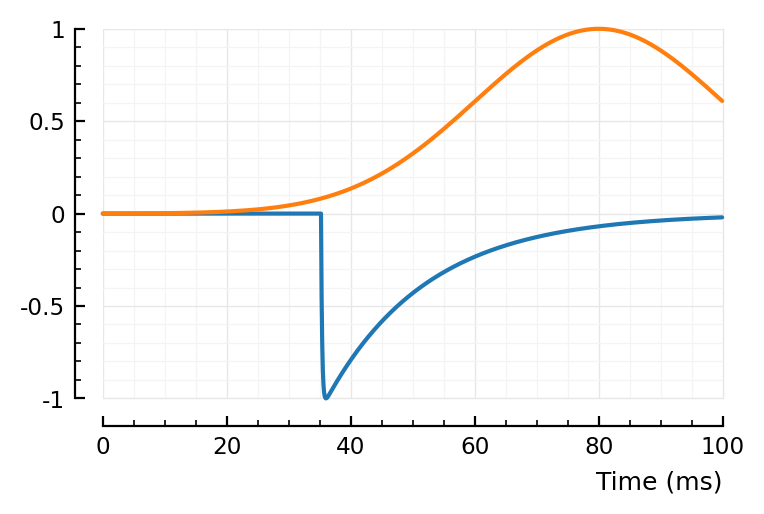

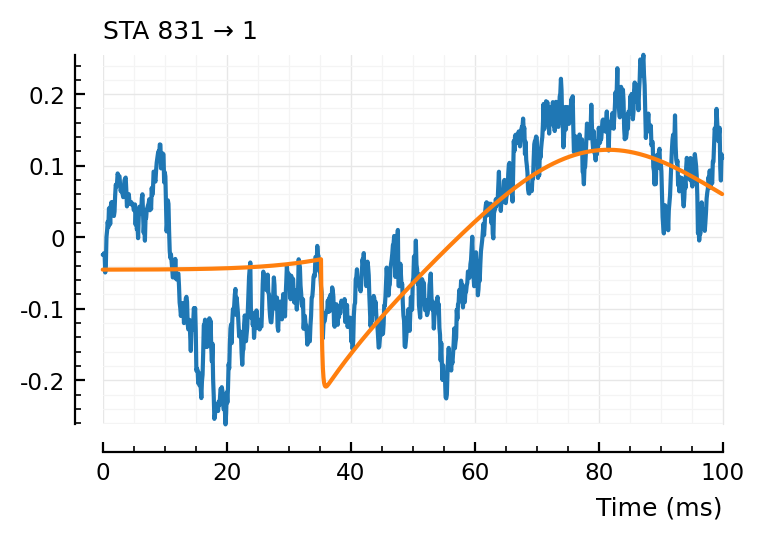

In [30]:
fit_STA.([988, 894, 831]);

The first one could use the more important weighting around the bump.

The last one.. Well it's the hardest inh input to detect.

We could do like a voting approach :P  : "curve_fit thinks :non-input, ptp-area thinks :inh".

### After changing max dip.weight to 0.6:

(From 1)

(tx_delay = 0.0147, bump = (τ1 = 0.0119, τ2 = 0.0124), dip = (loc = 0.08, width = 0.02, weight = 0.6), scale = -0.000177)


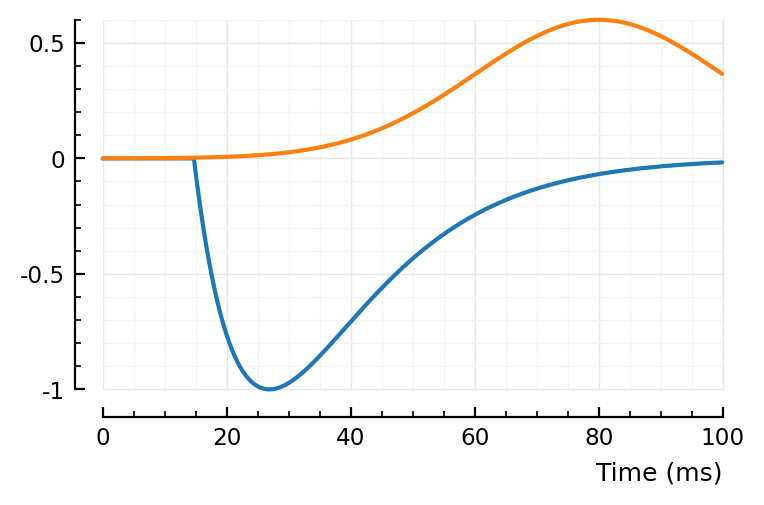

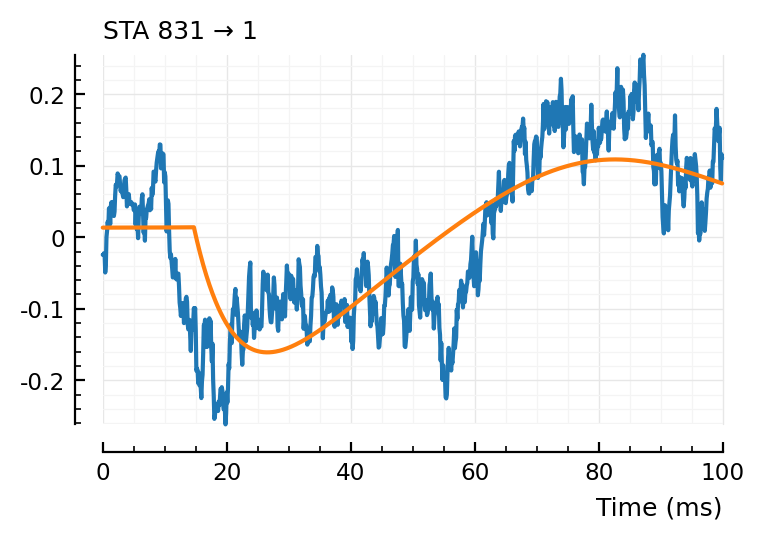

In [40]:
fit_STA.([831]);

Great, much better.

## Non-inputs

(tx_delay = 1.01E-05, bump = (τ1 = 0.00248, τ2 = 0.00248), dip = (loc = 0.08, width = 0.02, weight = 0.453), scale = -0.000271)
(tx_delay = 0.00944, bump = (τ1 = 0.0254, τ2 = 0.0254), dip = (loc = 0.0507, width = 0.0288, weight = 1), scale = 0.000327)
(tx_delay = 0.0169, bump = (τ1 = 0.0123, τ2 = 0.00573), dip = (loc = 0.08, width = 0.02, weight = 0.973), scale = -0.000189)
(tx_delay = 0.0165, bump = (τ1 = 0.017, τ2 = 0.0169), dip = (loc = 0.0596, width = 0.0471, weight = 0.149), scale = -6.92E-06)


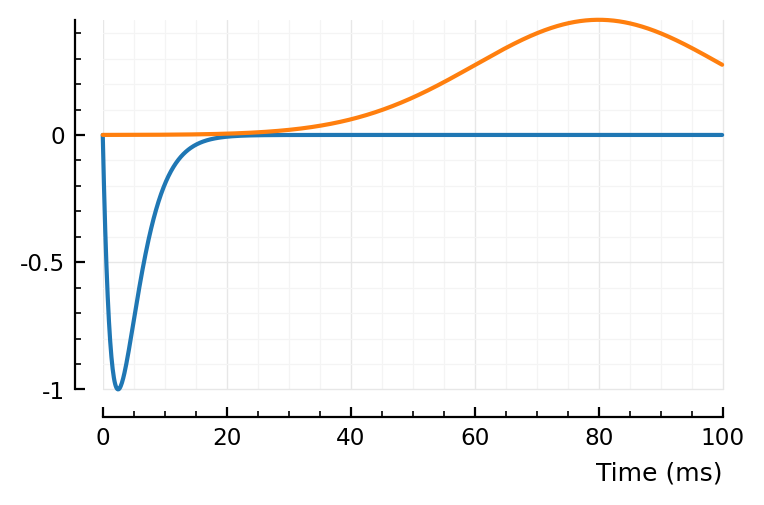

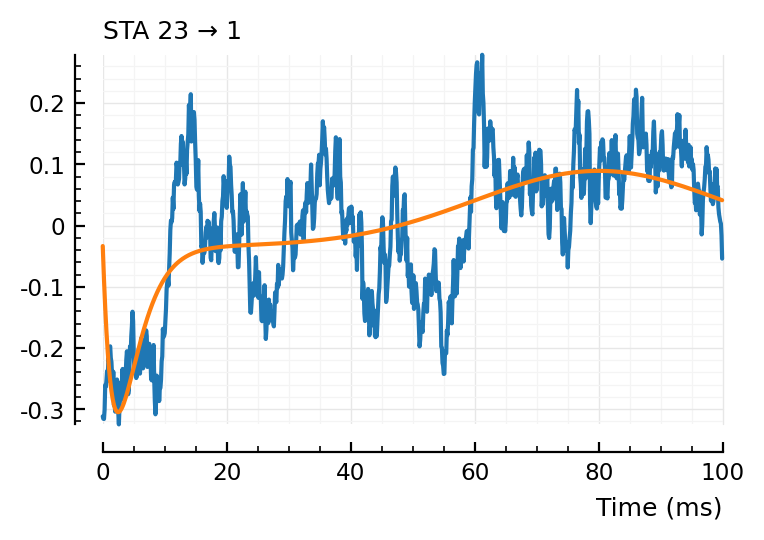

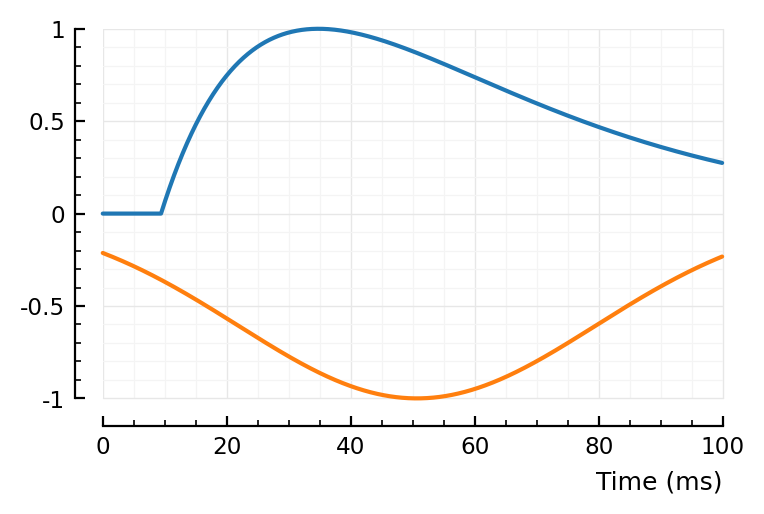

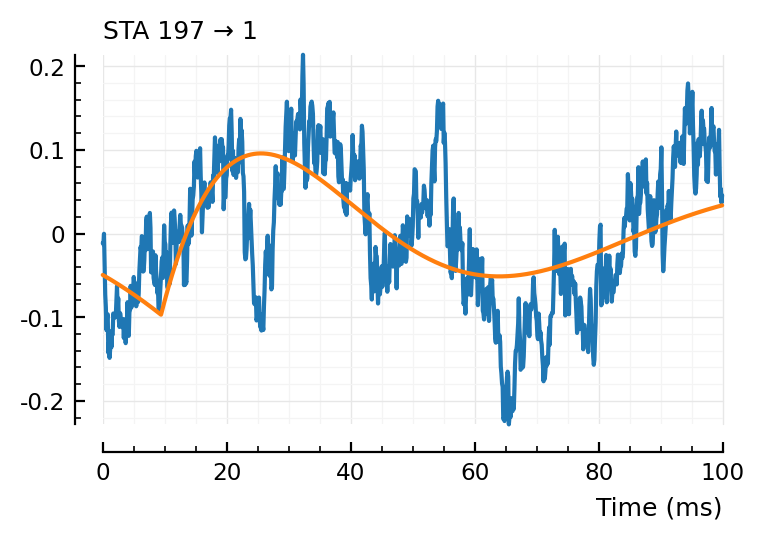

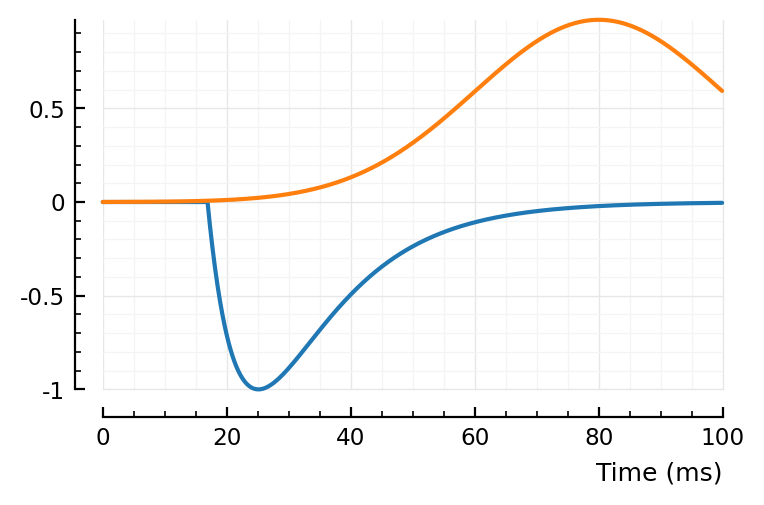

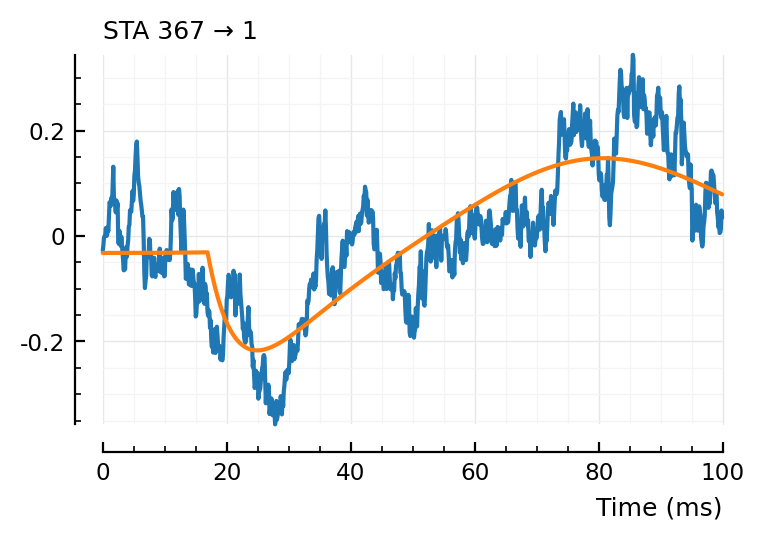

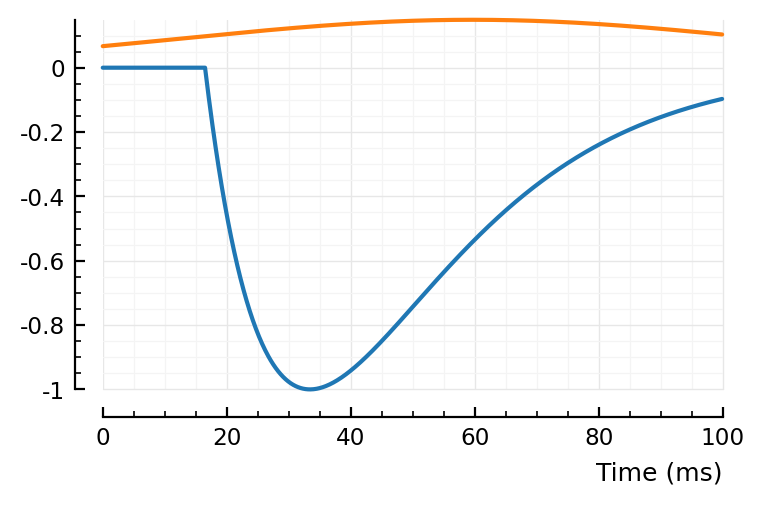

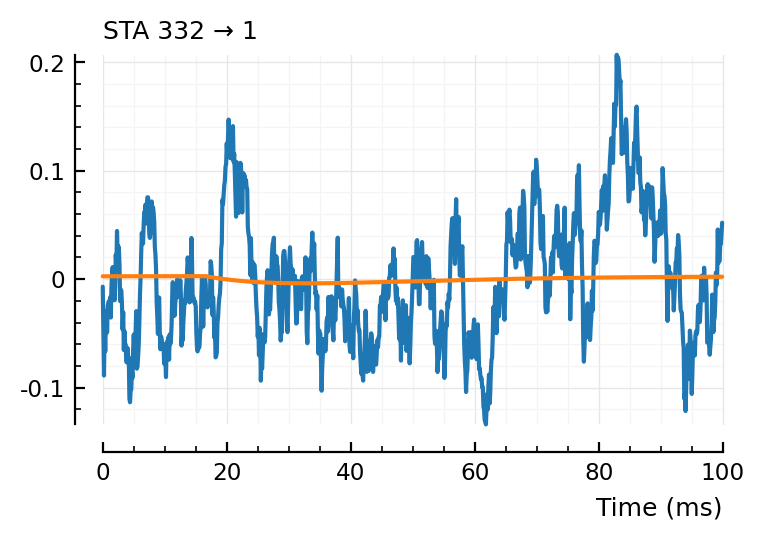

In [32]:
fit_STA.([23, 197, 367,332]);

- first and last (23, 332) good, nice and noisy
- 367 was a FP for the other two algo's too.

197.. this one together with 367 and the last of the inh's above makes me think the max weight of the bump is too high.

and again, that we should weight around the bump more somehow.

### After changing max dip.weight to 0.6:

(Middle two)

(tx_delay = 0.00866, bump = (τ1 = 0.016, τ2 = 0.016), dip = (loc = 0.0392, width = 0.0332, weight = 0.6), scale = 0.000186)
(tx_delay = 0.0161, bump = (τ1 = 0.00975, τ2 = 0.00799), dip = (loc = 0.08, width = 0.02, weight = 0.6), scale = -0.000234)


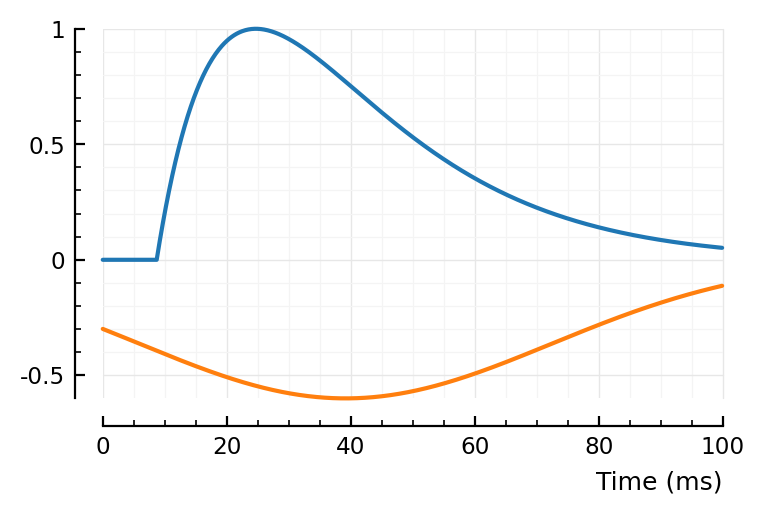

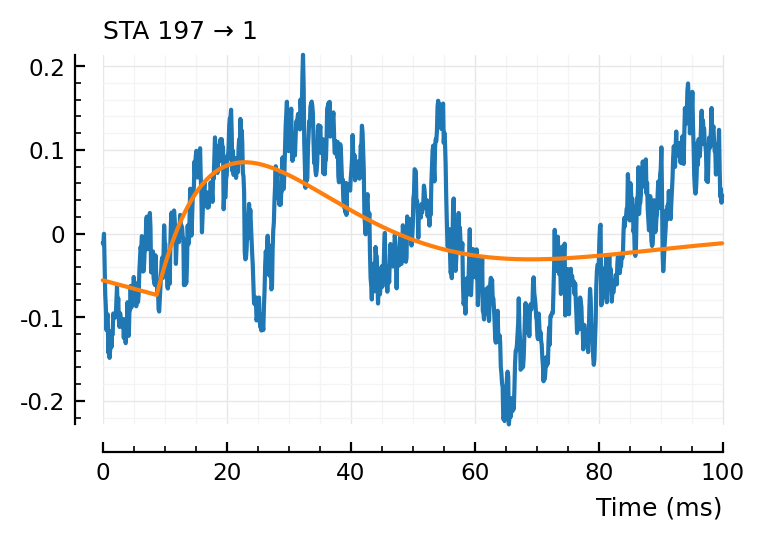

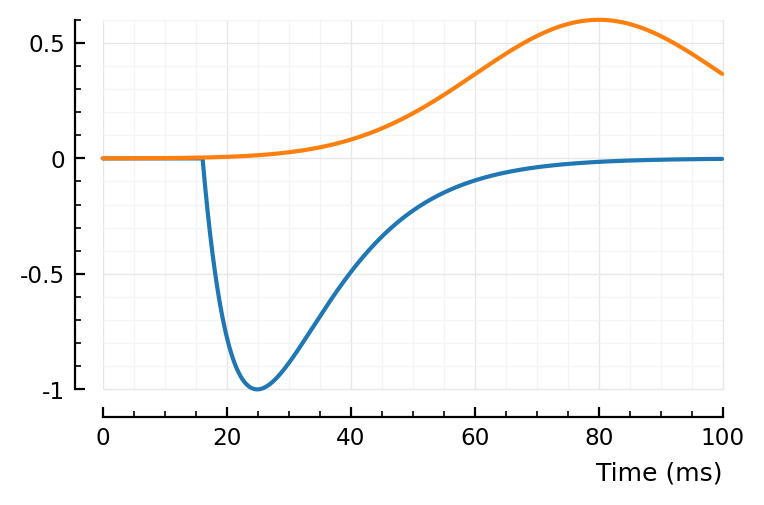

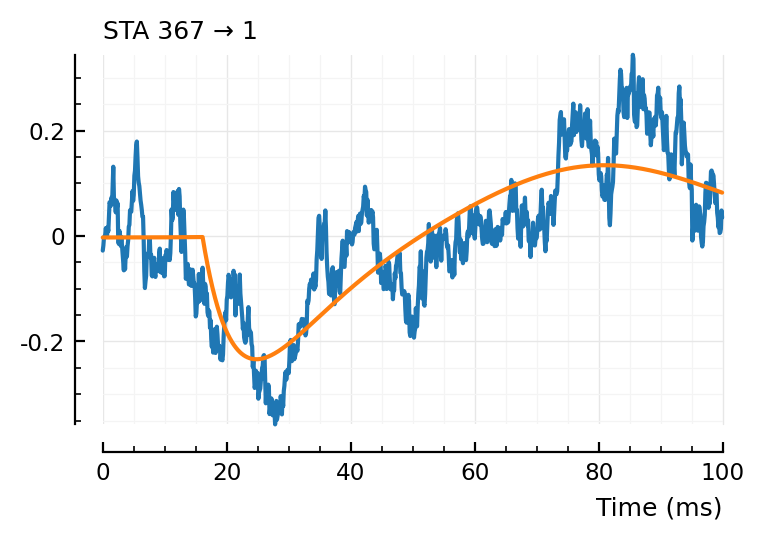

In [41]:
fit_STA.([197, 367]);

Nice, the 197 is much less well fit now.